In [1]:
import argparse
import random
import math

from tqdm import tqdm
import numpy as np
from PIL import Image

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

from dataset import MultiResolutionDataset
from model import StyledGenerator, Discriminator

from IPython.display import Image

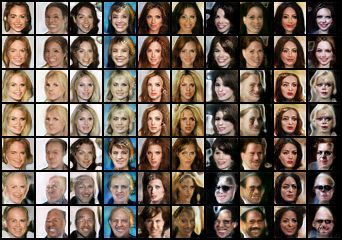

In [6]:
code_size = 512
batch_size = 16
n_critic = 1

def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)
    
generator = nn.DataParallel(StyledGenerator(code_size)).cuda()
discriminator = nn.DataParallel(
    Discriminator(fused=True, from_rgb_activate=True, embedding=False) # set embedding = True if you want use the trained embedding model
).cuda()
g_running = StyledGenerator(code_size).cuda()
g_running.train(False)

g_optimizer = optim.Adam(
    generator.module.generator.parameters(), lr=0.001, betas=(0.0, 0.99)
)
g_optimizer.add_param_group(
    {
        'params': generator.module.style.parameters(),
        'lr': 0.001 * 0.01,
        'mult': 0.01,
    }
)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))

accumulate(g_running, generator.module, 0)

ckpt = torch.load('./checkpoint/no_embedding_train_step-4.model') # set to embedding_train_step-4.model

generator.module.load_state_dict(ckpt['generator'])
discriminator.module.load_state_dict(ckpt['discriminator'])
g_running.load_state_dict(ckpt['g_running'])
g_optimizer.load_state_dict(ckpt['g_optimizer'])
d_optimizer.load_state_dict(ckpt['d_optimizer'])

# 0: bald, 1: black_hair, 2: blond_hair, 3: brown_hair, 4: eyeglasses, 5: gray_hair, 6: male, 7: mustache, 8: no_beard, 9: smiling
filtered_sample_feature_tensors = [
    # black hair, no beard, smiling
    torch.tensor([-1,  1, -1, -1, -1, -1, -1, -1,  1,  1], dtype=torch.float32).repeat(10, 1).cuda(),
    # brown hair, no beard, smiling
    torch.tensor([-1, -1, -1,  1, -1, -1, -1, -1,  1,  1], dtype=torch.float32).repeat(10, 1).cuda(),
    # blond hair, no beard,
    torch.tensor([-1, -1,  1, -1, -1, -1, -1, -1,  1, -1], dtype=torch.float32).repeat(10, 1).cuda(),
    # blond hair, no beard, eyeglasses
    torch.tensor([-1, -1,  1, -1,  1, -1, -1, -1,  1, -1], dtype=torch.float32).repeat(10, 1).cuda(),
    # male, brown hair, no beard
    torch.tensor([-1, -1, -1,  1, -1, -1,  1, -1,  1, -1], dtype=torch.float32).repeat(10, 1).cuda(),
    # male, gray hair, no beard, eyeglasses
    torch.tensor([-1, -1, -1, -1,  1,  1,  1, -1,  1, -1], dtype=torch.float32).repeat(10, 1).cuda(),
    # male, bald, mustache, smiling
    torch.tensor([ 1, -1, -1, -1, -1, -1,  1,  1, -1,  1], dtype=torch.float32).repeat(10, 1).cuda(),
]

latent_size = 512
step = 3            # 32x32
alpha = 1

images = []
with torch.no_grad():
    rand_vals = torch.randn(10, latent_size).cuda()
    for feature_tensor in filtered_sample_feature_tensors:
        copy = rand_vals.clone()
        images.append(
            generator(
                copy,
                feature_tensor,
                step=step,
                alpha=alpha,
            ).data.cpu()
        )


utils.save_image(
    torch.cat(images, 0),
    f'custom_sample.png',
    nrow=10,
    normalize=True,
    range=(-1, 1),
)

Image(filename='custom_sample.png') 